# Differentiate heavy drinking episodes and sober period with accelerometer data

## 1. Introduction

Excessive alcohol consumption leads to 5.3% of all deaths worldwide [WHO 2018] and yet is preventable. Promising strides have been made towards creating Just-In-Time Adaptive Interventions (JITAIs) delivered through mobile applications just before the beginning of a heavy drinking episodes. Research suggests timely notification reduces this risky behaviour and frequent notifications reduces intervention effectiveness, emphasising the timeliness and accuracy of these notifications. However, identifing heavy drinking episodes is challenging because of the unpredictablity of such episodes and the unavailability of blood alcohol content (BAC) data without selection bias. Hence, creating a classifier which accurately predicts heavy drinking episodes apart from the sober period is crucial. This paper [Learning to detect heavy drinking episodes using smartphone accelerometer data](https://ceur-ws.org/Vol-2429/paper6.pdf) proposes an alternative approach, where accelerometer data is used to predict heavy drinking episides and deliver JITAIs accurately. This project makes use of the data collected from this research to employ permutation entropy (PE) and permutation complexity (PC) methods to differentiate the heavy drinking episodes from the sober period.

Project on GitHub - https://github.com/ArtMax247/Intoxication-prediction-on-bar-crawl-data/tree/main

### 2. Understanding the data

This dataset contains two data tables
1. Accelerometer data - contains the x,y,z movement of all the participants collected from their smartphone at a frequency of 40Hz
2. TAC data - obtained from the SCRAM ankle bracelet for individual participants and are stored in different files

The TAC readings were preprocessed with a zero-phase low-pass filter to smooth noise without shifting phase and were shifted backwards by 45 minutes so the labels more closely match the true intoxication of the participant (since alcohol takes about 45 minutes to exit through the skin)

In [95]:
#Import relevant libraries

import os
import pandas as pd
import numpy as np
import ordpy as ordpy
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [96]:
#Load relevant py files
%run function.py

In [97]:
#Read the accelerometer data and print unique participant id values
df_acc = pd.read_csv("bar+crawl+detecting+heavy+drinking/data/all_accelerometer_data_pids_13.csv")
pd.unique(df_acc['pid'])

array(['JB3156', 'CC6740', 'SA0297', 'PC6771', 'BK7610', 'DC6359',
       'MC7070', 'MJ8002', 'BU4707', 'JR8022', 'HV0618', 'SF3079',
       'DK3500'], dtype=object)

In [98]:
#Display all columns in the dataset
df_acc.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14057567 entries, 0 to 14057566
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   time    14057567 non-null  int64  
 1   pid     14057567 non-null  object 
 2   x       14057567 non-null  float64
 3   y       14057567 non-null  float64
 4   z       14057567 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 536.3+ MB


In [99]:
#Function to plot all the three axis of a selected participant
def plot_pid_xyz(df_acc,pid,tac):
    df_pid = df_acc[df_acc['pid']==pid]
    
    #Create subplot with 3 rows
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    axes = axes.flatten()
    
    sns.lineplot(data=df_pid,x='time',y='x',color='blue',ax=axes[0],label='X-axis')
    sns.lineplot(data=df_pid,x='time',y='y',color='red',ax=axes[1],label='Y-axis')
    sns.lineplot(data=df_pid,x='time',y='z',color='green',ax=axes[2],label='Z-axis')

    axes[0].set_title('Accelerometer data of ' + pid, loc='left')
    plt.legend()
    plt.show

    #Line chart for dataset with TAC reading
    if tac == 'tac':
        plt.figure(figsize=(12,2))
        sns.lineplot(df_pid,x='time',y='TAC_Reading',color='blue',label='TAC_reading')
        plt.axhline(0.08,ls='-',color='red',label='TAC threshold')
        plt.title('TAC readings of - ' + pid,loc='left')
        plt.legend(loc='upper right')
        plt.show()

In [100]:
#Select a participant
selected_pid = 'SA0297'

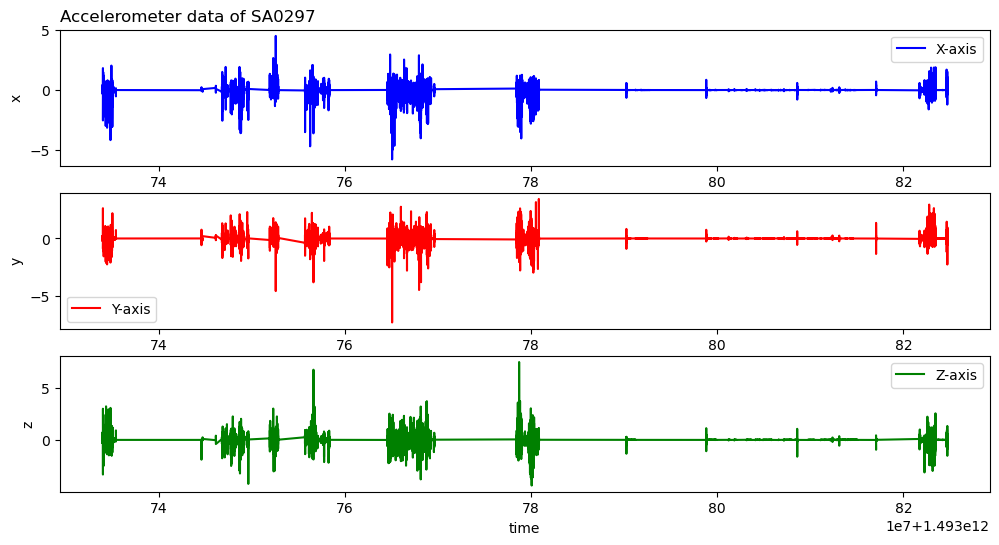

In [101]:
#Display the corresponding accelerometer data
plot_pid_xyz(df_acc,selected_pid,'no_tac')

In [102]:
#Function to concatenate all clean_tac files and extract pid name from the file name
def combine_tac(path):
    appended_data = []
    directory = os.fsencode(path)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        df = pd.read_csv(path + filename)
        df['pid'] = filename.split("_")[0]
        appended_data.append(df)
    df = pd.concat(appended_data).sort_values(['timestamp'], ascending=True).reset_index(drop=True)
    # Create binary flag based on the TAC threshold
    df.loc[df.TAC_Reading > 0.08, "intoxicated"] = 1
    df.loc[df.TAC_Reading <= 0.08, "intoxicated"] = 0
    return df

In [103]:
#Read the combined tac file and print a subset of the data
df_ctac = combine_tac("bar+crawl+detecting+heavy+drinking/data/clean_tac/")
df_ctac.head()

,timestamp,TAC_Reading,pid,intoxicated
0,1493716723,-0.010229,SA0297,0.0
1,1493717859,0.000043,PC6771,0.0
2,1493718546,-0.002512,SA0297,0.0
3,1493718714,-0.000482,BK7610,0.0
4,1493718714,-0.000482,BU4707,0.0


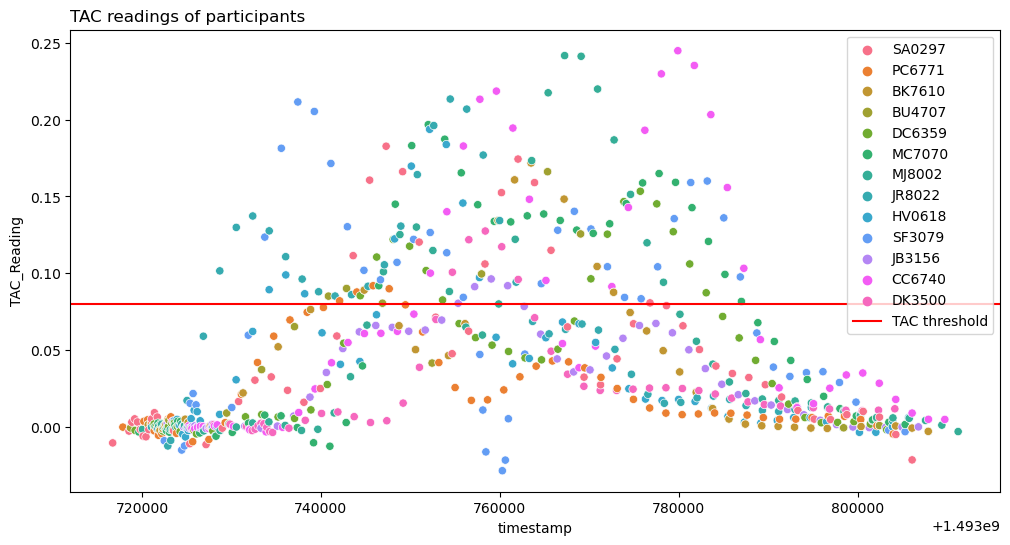

In [104]:
#Plot the TAC reading of all the participants to compare with the TAC threshold
plt.figure(figsize=(12,6))
sns.scatterplot(df_ctac,x='timestamp',y='TAC_Reading',hue='pid')
plt.axhline(0.08,ls='-',color='red',label='TAC threshold')
plt.title('TAC readings of participants',loc='left')
plt.legend()
plt.show()

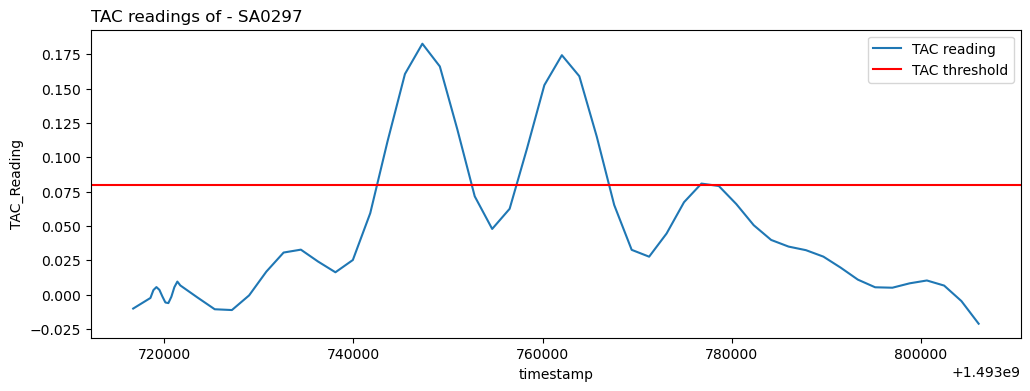

In [105]:
#Plot the TAC reading of the selected participant to compare with threshold
df_cpid = df_ctac[df_ctac['pid']==selected_pid]
plt.figure(figsize=(12,4))
sns.lineplot(df_cpid,x='timestamp',y='TAC_Reading',label='TAC reading')
plt.axhline(0.08,ls='-',color='red',label='TAC threshold')
plt.title('TAC readings of - ' + selected_pid,loc='left')
plt.legend(loc="upper right")
plt.show()

From the above analysis, we understand there are 13 participants in the dataset and all of them have recorded TAC readings. Heavy drinking episodes are defined by a high TAC reading > 0.08

The data needs to be cleaned and preprocessed to differentiate between the intoxicated and sober periods to create two different states in the time series. Once the two states (intoxicated, sober) have been established, permutation entropy and complexity can be calculated to identify the difference between the two states.

### 3. Data Preprocessing

In [106]:
#Get the data points with 0 as time
df_acc_time = df_acc[df_acc['time']==0]
df_acc_time.head()

,time,pid,x,y,z
0,0,JB3156,0.0,0.0,0.0
1,0,CC6740,0.0,0.0,0.0


We are merging the accelerometer data and the TAC reading data by converting the timestamp of accelerometer data from milliseconds to seconds. We can then map the TAC reading value based on pid and timestamp in seconds.

In [107]:
#Remove the rows with 0 as time
df_acc = df_acc[df_acc['time']!=0]

#Create timestamp column and convert time from milliseconds to seconds
df_acc['timestamp'] = np.floor(df_acc['time']/1000).astype(int)
df=df_acc.sort_values(by='timestamp')
df=df.reset_index(drop=True)
df.head(5)

,time,pid,x,y,z,timestamp
0,1493733882409,SA0297,0.0758,0.0273,-0.0102,1493733882
1,1493733882455,SA0297,-0.0359,0.0794,0.0037,1493733882
2,1493733882500,SA0297,-0.2427,-0.0861,-0.0163,1493733882
3,1493733883991,SA0297,-0.0561,-0.0226,0.0134,1493733883
4,1493733883977,SA0297,0.0070,-0.0050,-0.0849,1493733883


In [108]:
#Combine the accelerometer and TAC data using time and participant id
df_merged = df_acc.merge(df_ctac, on=['timestamp','pid'], how='inner')
df_merged.head()

,time,pid,x,y,z,timestamp,TAC_Reading,intoxicated
0,1493734448017,SA0297,0.1312,0.0432,0.0034,1493734448,0.032672,0.0
1,1493734448062,SA0297,0.2734,0.1197,0.0968,1493734448,0.032672,0.0
2,1493734448107,SA0297,0.1514,0.1886,0.0375,1493734448,0.032672,0.0
3,1493734448156,SA0297,-0.0914,0.0496,0.0534,1493734448,0.032672,0.0
4,1493734448197,SA0297,-0.7935,-0.5184,0.3967,1493734448,0.032672,0.0


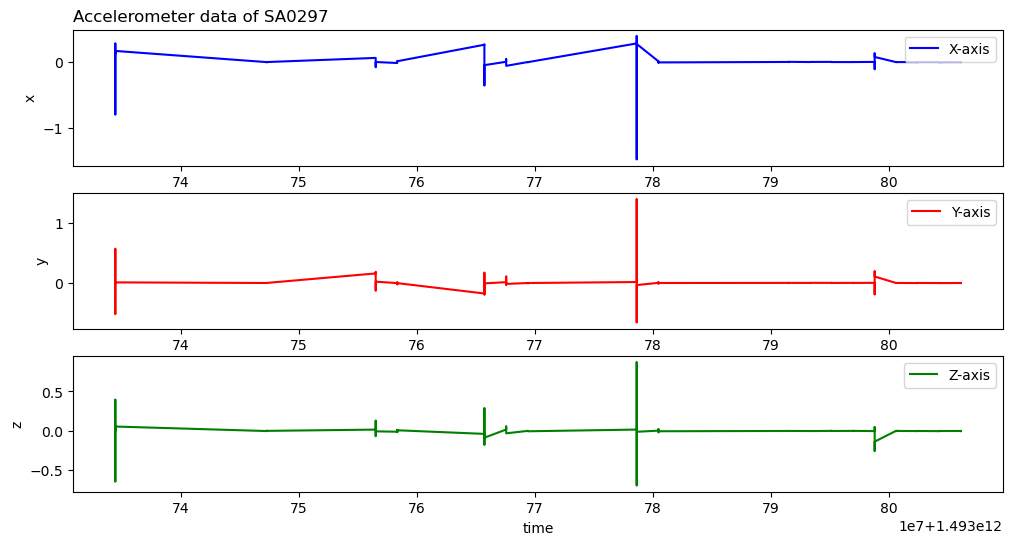

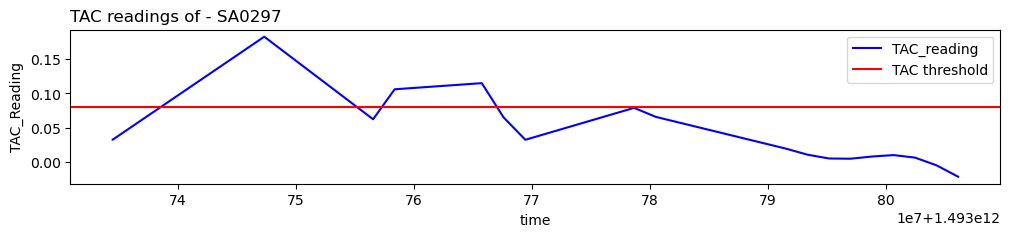

In [109]:
#Plot the accelerometer and TAC data for the selected participant from the merged data
plot_pid_xyz(df_merged,selected_pid,'tac')

### 4. Permutation Entropy and Permutaion Complexity Calculations

Our objective is to identify PE and PC values that can be used in differentiating between intoxicated and sober state, given an accelerometer time series data. We calculate PE and PC values for each axis time series. While calculating PE and PC, it is important to segment the data so we get the PE, PC values for each corresponding TAC reading. Hence, we segment the given series by 40, which is the frequency of accelerometer data.

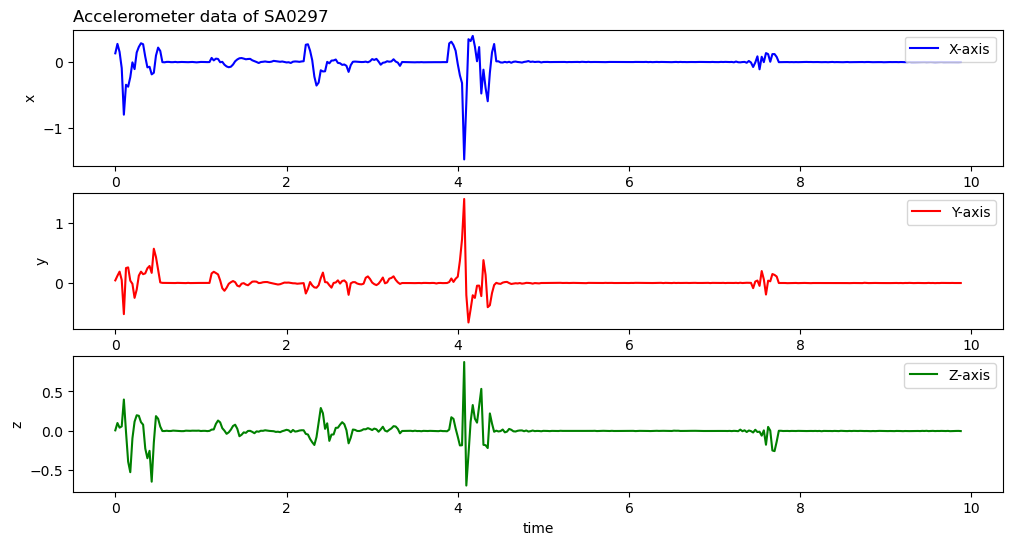

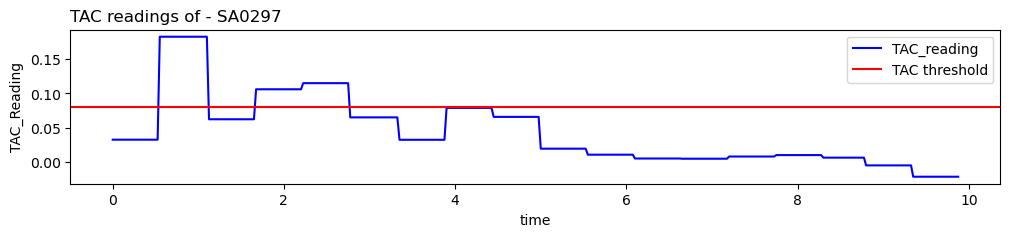

In [110]:
#Create blank data frames
df_PEPC = df_merged.head(1)
df_PEPC = df_PEPC.drop([0])
df_concat = df_PEPC

#Loop through for each participant 
for pid in df_merged['pid'].unique():

    df_pid = df_merged.loc[(df_merged['pid']==pid)]
    n = df_pid['x'].size
    df_concat = df_merged.head(1)
    df_concat = df_concat.drop([0])

    #Loop through for each unique TAC reading value for segmenting the dataset
    for val in df_merged['TAC_Reading'].unique():
        df = df_pid[df_pid['TAC_Reading']==val]
        df = df.reset_index(drop=True)

        #Calculate PE and PC values for axis
        x = ordinal_patterns(df['x'],3,1)
        y = ordinal_patterns(df['y'],3,1)
        z = ordinal_patterns(df['z'],3,1)
        df['XPE'] = permutaion_entropy(x)
        df['YPE'] = permutaion_entropy(y)
        df['ZPE'] = permutaion_entropy(z)
        df['XPC'] = permutaion_complexity(x)
        df['YPC'] = permutaion_complexity(y)
        df['ZPC'] = permutaion_complexity(z)
        df_concat = pd.concat([df_concat,df])
    
    #Get accelerometer and TAC reading at 40Hz frequency
    df_concat['time'] = np.arange(df_concat['x'].size)/40
    df_PEPC = pd.concat([df_PEPC,df_concat])

df_PEPC.to_csv('test.csv')

#Plot the accelerometer and TAC data for the seleted participant
plot_pid_xyz(df_PEPC,selected_pid,'tac')

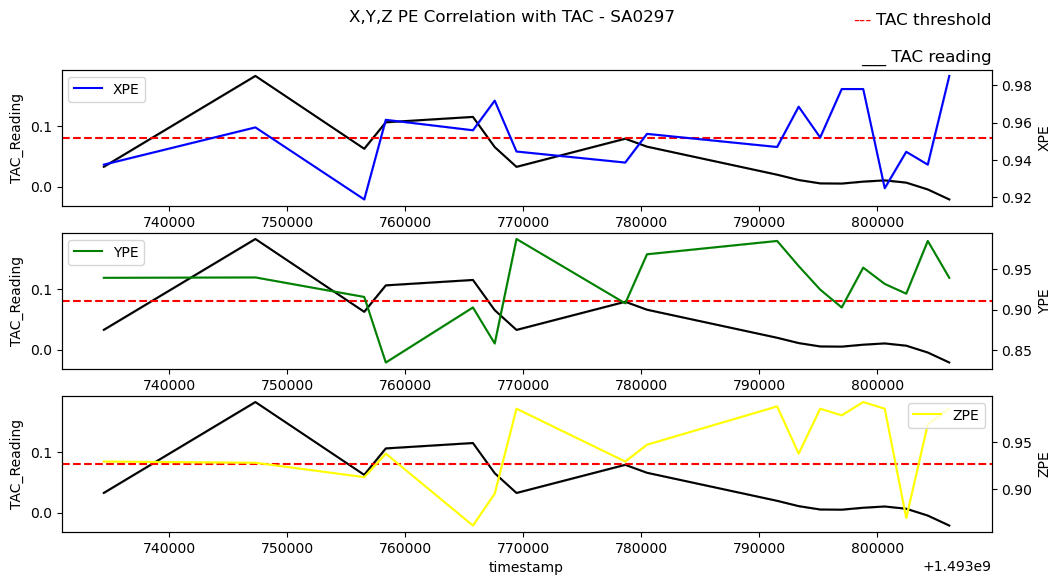

In [111]:
#Plot XPE, YPE, ZPE for the selected participant
df_plot = df_PEPC[df_PEPC['pid']==selected_pid]
df_plot.sort_values(by='timestamp')

df_plot['TAC_Reading'] = df_plot['TAC_Reading'].astype(float)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axes = axes.flatten()

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[0])
axes[0].axhline(0.08,ls='--',color='red')
axy = axes[0].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='XPE',color='blue',ax=axy,label='XPE')

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[1])
axes[1].axhline(0.08,ls='--',color='red')
axy = axes[1].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='YPE',color='green',ax=axy,label='YPE')

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[2])
axes[2].axhline(0.08,ls='--',color='red')
axy = axes[2].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='ZPE',color='yellow',ax=axy,label='ZPE')

fig.suptitle('X,Y,Z PE Correlation with TAC - ' + selected_pid)
axes[0].set_title('___ TAC reading', loc='right')
fig.text(0.80, 0.95, "---", ha="right", va="bottom", size="large",color="red")
fig.text(0.90, 0.95, "TAC threshold", ha="right", va="bottom", size="large",color="black")

plt.legend(loc='upper right')
plt.show()


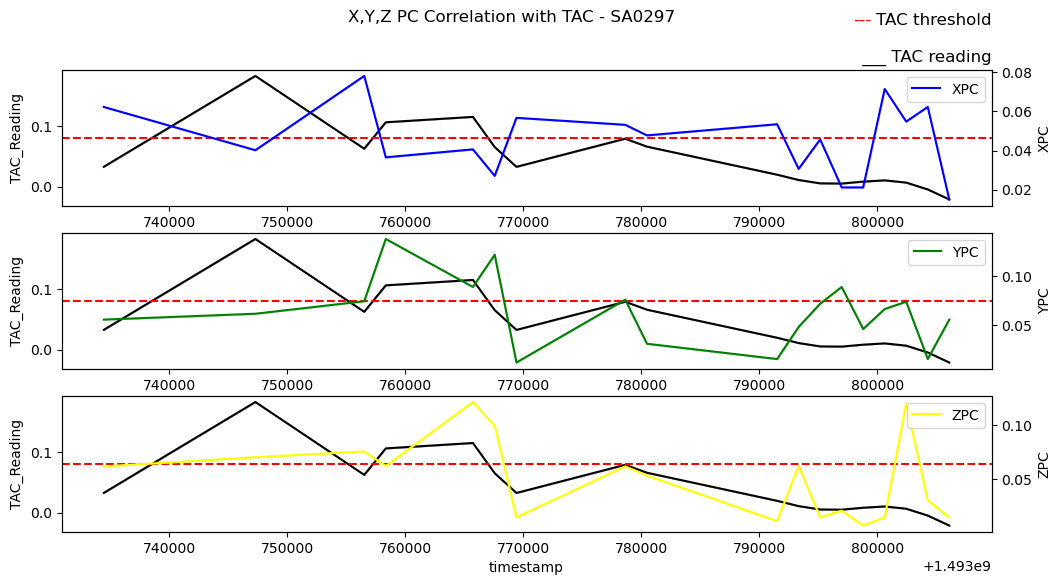

In [112]:
#Plot XPC, YPC, ZPC for the selected participant
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axes = axes.flatten()

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[0])
axes[0].axhline(0.08,ls='--',color='red')
axy = axes[0].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='XPC',color='blue',ax=axy,label='XPC')

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[1])
axes[1].axhline(0.08,ls='--',color='red')
axy = axes[1].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='YPC',color='green',ax=axy,label='YPC')

sns.lineplot(data=df_plot,x='timestamp',y='TAC_Reading',color='black',ax=axes[2])
axes[2].axhline(0.08,ls='--',color='red')
axy = axes[2].twinx()
sns.lineplot(data=df_plot,x='timestamp',y='ZPC',color='yellow',ax=axy,label='ZPC')

fig.suptitle('X,Y,Z PC Correlation with TAC - ' + selected_pid)
axes[0].set_title('___ TAC reading', loc='right')
fig.text(0.80, 0.95, "---", ha="right", va="bottom", size="large",color="red")
fig.text(0.90, 0.95, "TAC threshold", ha="right", va="bottom", size="large",color="black")

plt.legend(loc='upper right')
plt.show()

PE is a measure of the diversity of ordinal patterns in a time series and is often used as an indicator of its complexity or randomness. The similarity between the time series and its PE values indicates that the complexity or irregularity of the time series remains relatively stable over time. 

In this scenario, we can observe similarity of patterns between XPE with the TAC reading. While YPE and ZPE show some pattern overlap with the TAC reading, we can observe high deviations in PE values when there is even a slight change in the TAC reading.

With PC calculations, we can observe strong similarity in the pattern for YPC and ZPC with the TAC reading, while XPC is highly sentitive of TAC reading changes.

Even though this is interpretable, it is hard to observe how PE and PC in general varies for sober and intoxicated states. To get to a unified PE and PC values across the 3 axes, we calculate resultant vector (RE) with the following formula: RE= √(x^2 )+y^2+z^2

In [113]:
#Calculate resultant vectors for PE and PC
df_PEPC['RvPE'] = np.sqrt(df_PEPC['XPE']**2 + df_PEPC['YPE']**2 + df_PEPC['ZPE']**2)
df_PEPC['RvPC'] = np.sqrt(df_PEPC['XPC']**2 + df_PEPC['YPC']**2 + df_PEPC['ZPC']**2)

### 5. Correlation of entropy and complexity with TAC Reading

With the resultant vectors of PE (RvPE) and PC (RvPC), we can now plot TAC vs RvPE and TAC vs RvPC graphs for all the participants to further validate the similarity observed from the individual axes PE and PC values. The line is smoothed with a rolling window method to reduce the extreme changes in the trend.

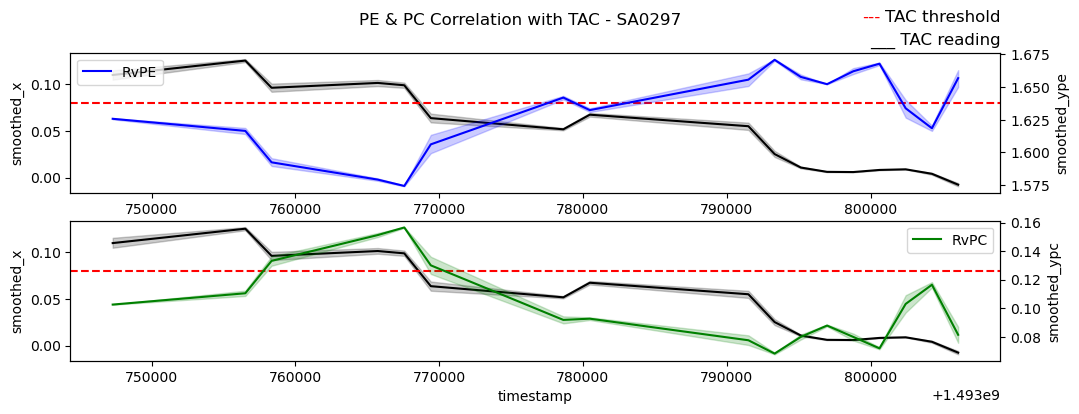

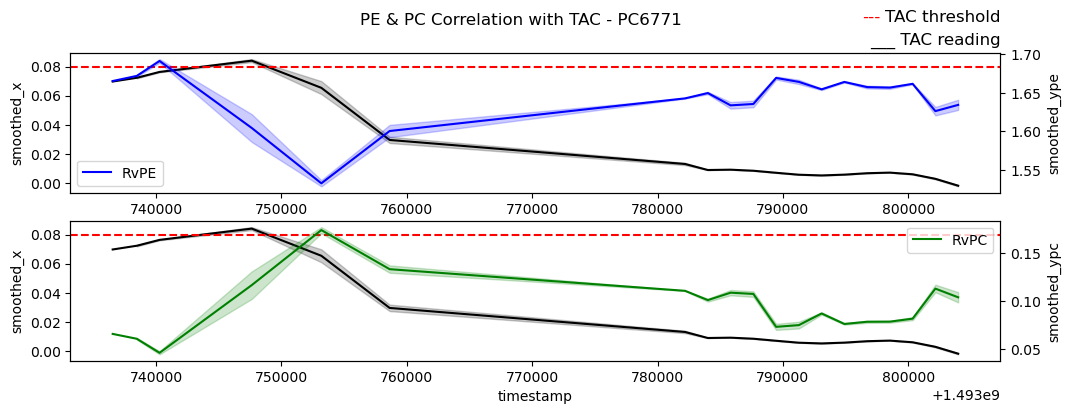

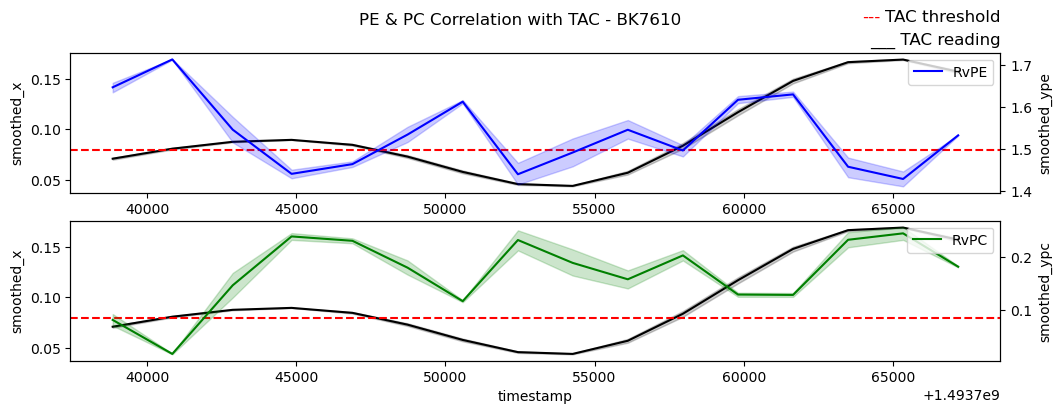

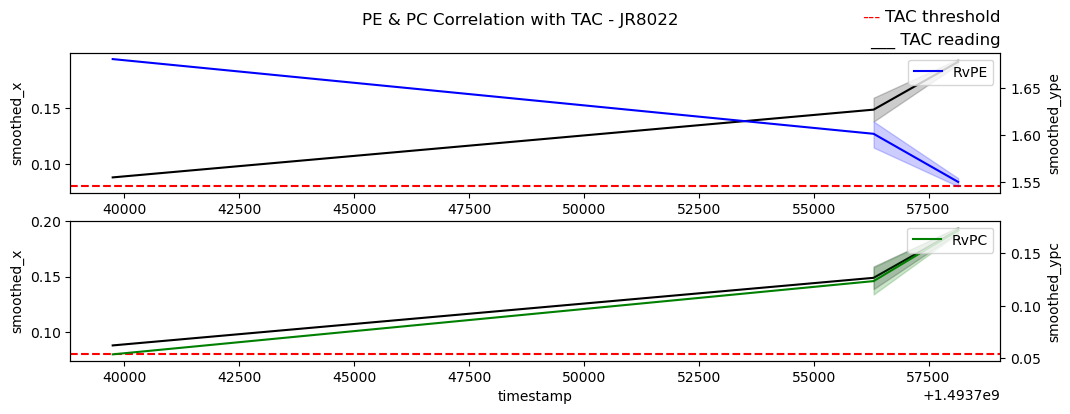

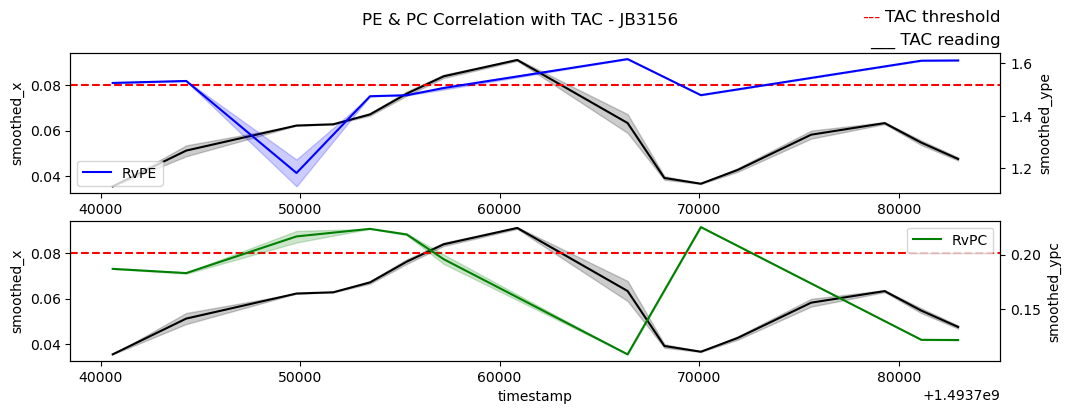

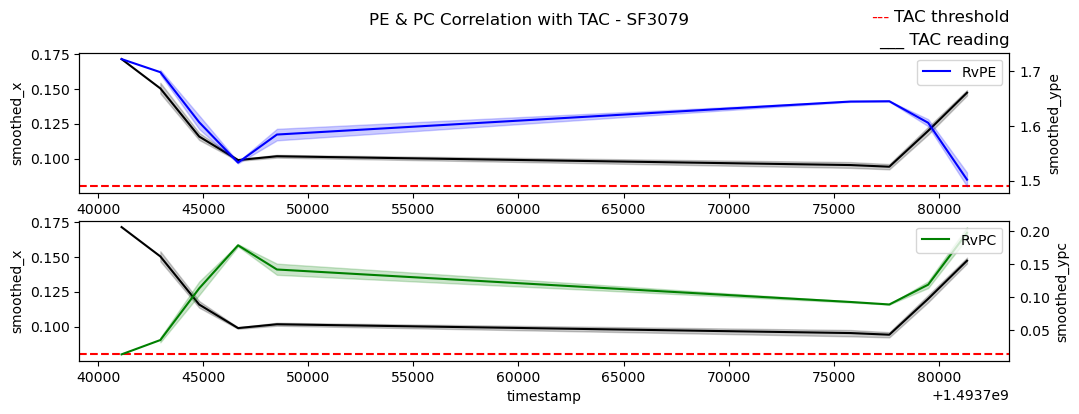

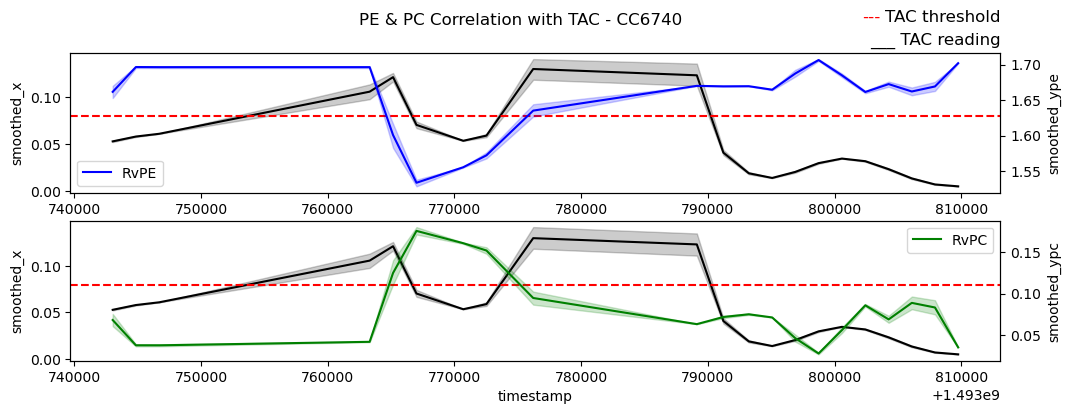

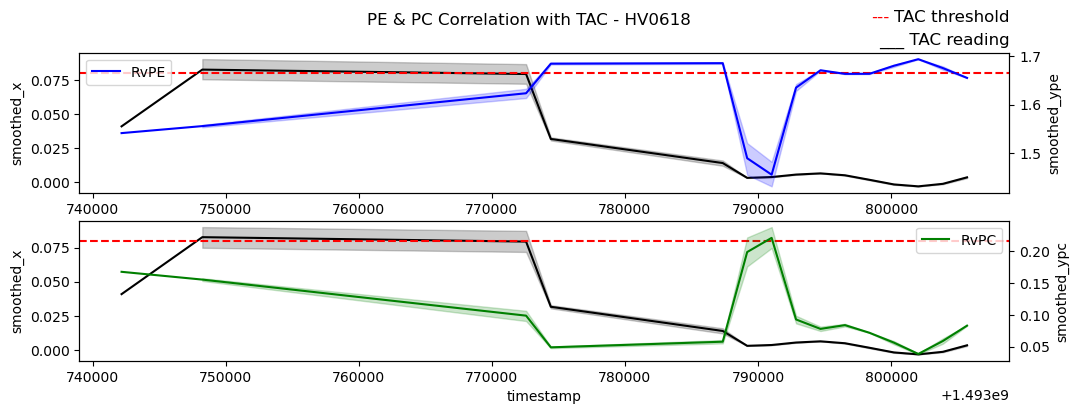

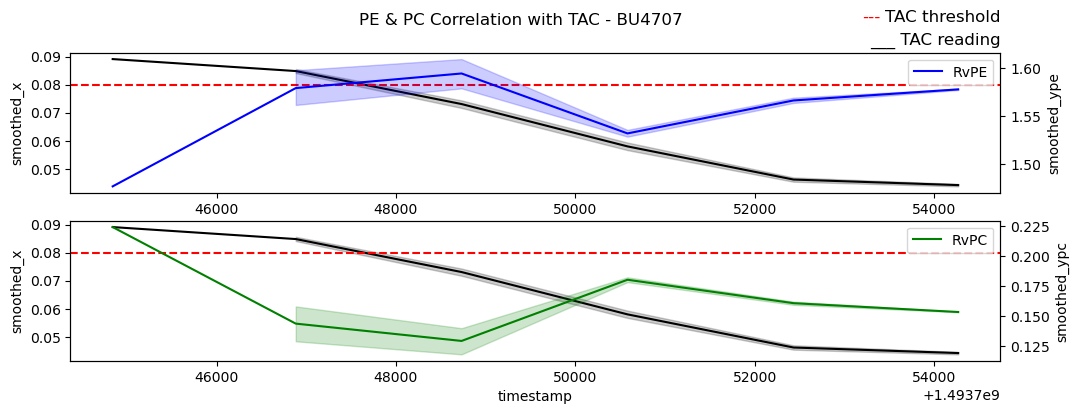

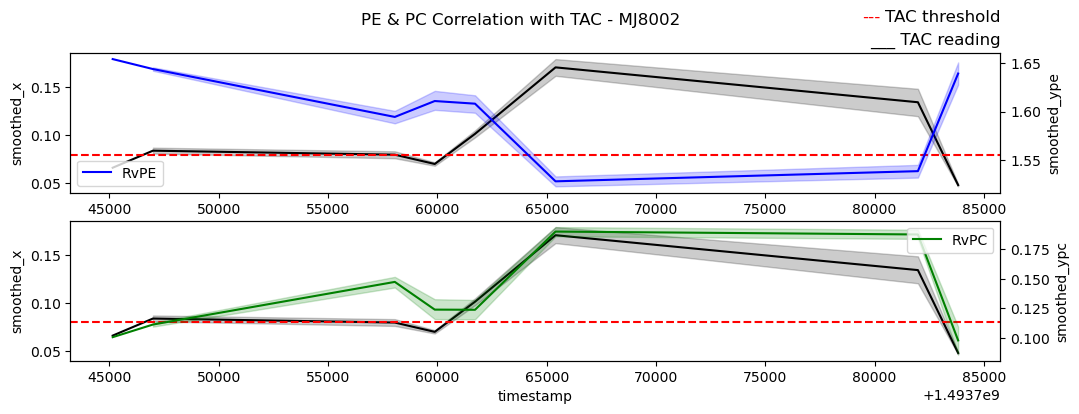

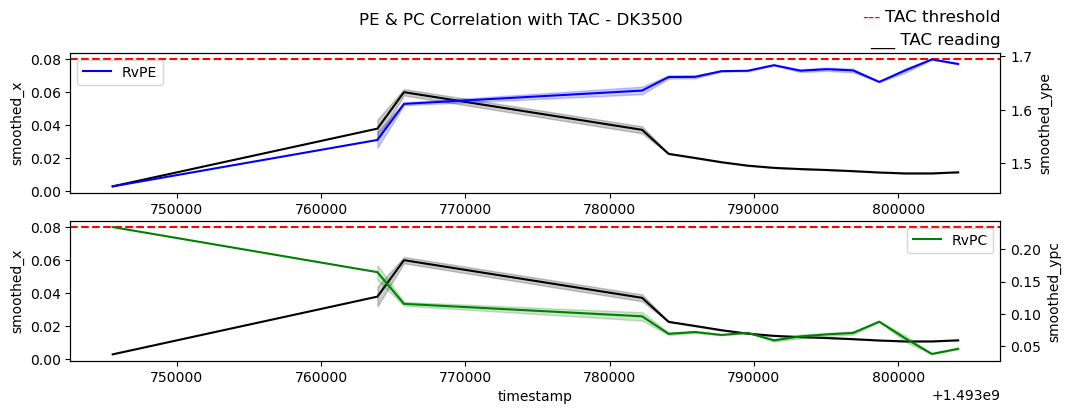

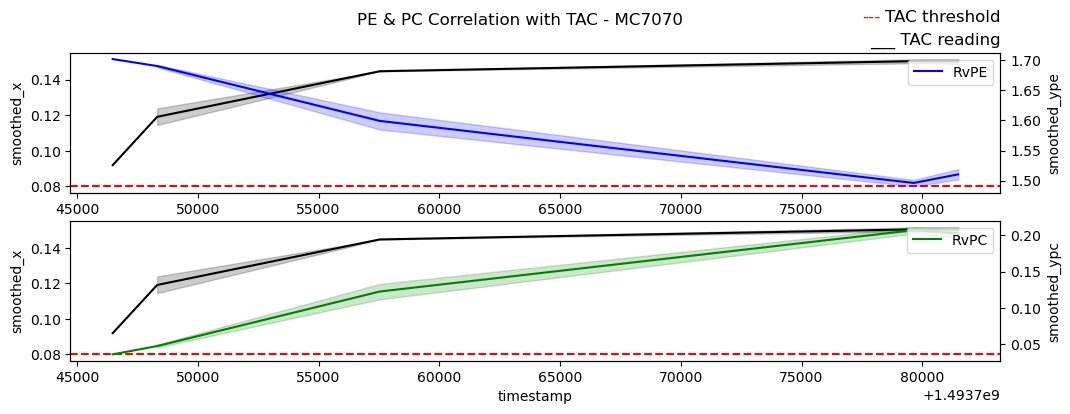

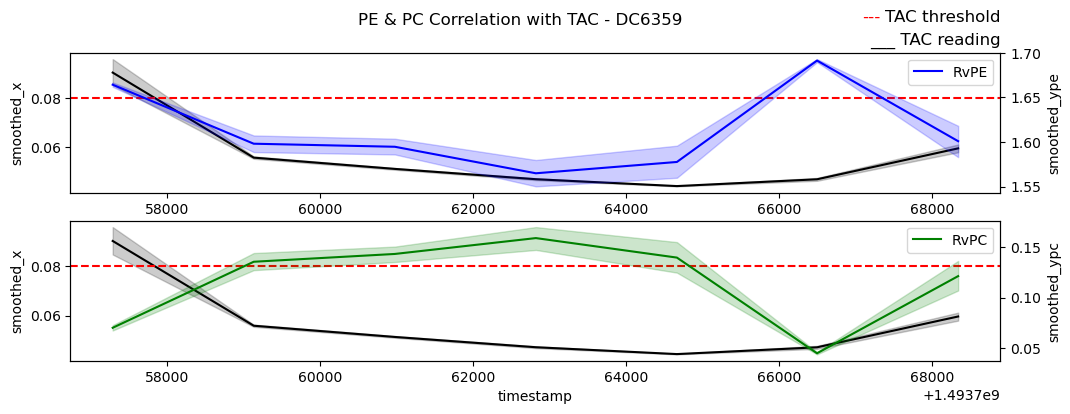

In [114]:
#Loop through each participant to plot TAC and resultant vector PE and PC
for pid in df_PEPC['pid'].unique():

    df_pid = df_PEPC[df_PEPC['pid']==pid].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
    axes = axes.flatten()

    df_pid['smoothed_x'] = df_pid['TAC_Reading'].rolling(40).mean()

    sns.lineplot(data=df_pid,x='timestamp',y='smoothed_x',color='black',ax=axes[0])
    axes[0].axhline(0.08,ls='--',color='red')
    axy = axes[0].twinx()
    df_pid['smoothed_ype'] = df_pid['RvPE'].rolling(40).mean()
    sns.lineplot(data=df_pid,x='timestamp',y='smoothed_ype',color='blue',ax=axy,label='RvPE')

    sns.lineplot(data=df_pid,x='timestamp',y='smoothed_x',color='black',ax=axes[1])
    axes[1].axhline(0.08,ls='--',color='red')
    axy = axes[1].twinx()
    df_pid['smoothed_ypc'] = df_pid['RvPC'].rolling(40).mean()
    sns.lineplot(data=df_pid,x='timestamp',y='smoothed_ypc',color='green',ax=axy,label='RvPC')

    fig.suptitle('PE & PC Correlation with TAC - ' + pid)
    axes[0].set_title('___ TAC reading', loc='right')
    fig.text(0.80, 0.95, "---", ha="right", va="bottom", size="large",color="red")
    fig.text(0.90, 0.95, "TAC threshold", ha="right", va="bottom", size="large",color="black")
    plt.legend(loc='upper right')
    plt.show()

From these graphs, we can observe strong similarity between PC and TAC readings in most cases like 'MC7070' and 'MJ8200'. Higher PC values indicate higher complexity or irregularity in the time series. This suggests that the data exhibits more diverse and unpredictable patterns of behavior. Lower PC values indicate lower complexity or regularity in the time series. This suggests that the data exhibits more ordered and predictable patterns of behavior. In this case, we can observe low PC levels in all the participants indicating ordered and predictable patterns of behavior.

For PE, we can observe some part of the time series is highly similar and other parts are highly different. In case of participant 'SJ0379', PE is strongly similar to the TAC reading in the initial part of the time series, and as the time progresses it becomes completely opposite to the TAC reading pattern. PE values can help identify periods of stability or instability in the time series. Higher PE values may indicate periods of increased variability or unpredictability, while lower PE values may indicate periods of more stable behavior. In this case, we observe high values of PE across all the participants.


#### 5.1 Classification using PE and PC values by normalization technique

To identify the method that has high similarity with the TAC readings, we are normalizing the data and the TAC threhold for each participant. We then calculate the intoxication flag for RvPE and RvPC using this normalized threshold. We now use this PE and PC intoxication flags as the predicted data to calculate accuracy.

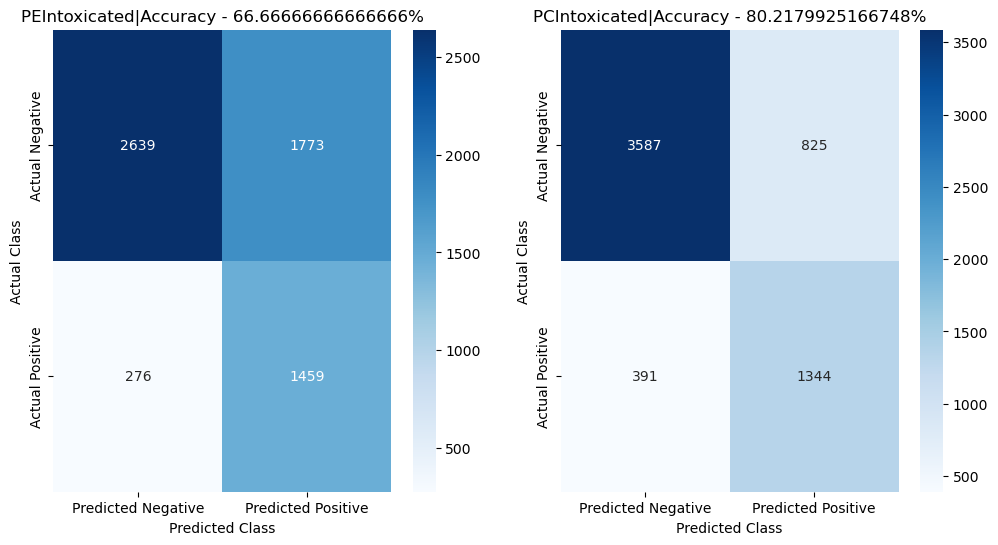

In [115]:
#Initialize dataframe to store normalized data
df_norm = df_PEPC

#Loop through each paricipant to calculate normalized TAC, PE and PC
for pid in df_norm['pid'].unique():
    df_pid = df_PEPC[df_PEPC['pid']==pid].reset_index(drop=True)
    df_to_scale = df_pid[['TAC_Reading','RvPE','RvPC']]

    #Normalize threshold value based on TAC reading value range
    threshold = 0.08
    min_tac = df_pid['TAC_Reading'].min()
    max_tac = df_pid['TAC_Reading'].max()
    normalized_threshold = (threshold - min_tac) / (max_tac - min_tac)

    #Defining min max scaler for normalization
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(df_to_scale)
    df_normalized = pd.DataFrame(normalized_values, columns=['TAC_Reading','RvPE','RvPC'])

    df_norm.loc[df_norm['pid']==pid, 'TAC_Reading_norm'] = df_normalized['TAC_Reading']
    df_norm.loc[df_norm['pid']==pid, 'RvPE_norm'] = df_normalized['RvPE']
    df_norm.loc[df_norm['pid']==pid, 'RvPC_norm'] = df_normalized['RvPC']
    df_norm.loc[df_norm['pid']==pid, 'normalized_threshold'] = normalized_threshold

#Create intoxication flag based on the normalized PE and PC values
df_norm.loc[df_norm['RvPE_norm'] >= df_norm['normalized_threshold'],'PEIntoxicated'] = 1
df_norm.loc[df_norm['RvPE_norm'] < df_norm['normalized_threshold'],'PEIntoxicated'] = 0

df_norm.loc[df_norm['RvPC_norm'] >= df_norm['normalized_threshold'],'PCIntoxicated'] = 1
df_norm.loc[df_norm['RvPC_norm'] < df_norm['normalized_threshold'],'PCIntoxicated'] = 0

#Plot confusion matrix for both PE and PC
col = ['PEIntoxicated','PCIntoxicated']
counter = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes = axes.flatten()

for val in col:
    #Create a confusion matrix
    conf_matrix = confusion_matrix(df_norm['intoxicated'], df_norm[val])

    #Convert confusion matrix to DataFrame for visualization
    conf_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

    # Plot confusion matrix as a heatmap
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues',ax=axes[counter])
    accuracy = accuracy_score(df_norm['intoxicated'], df_norm[val])
    axes[counter].set_title(val + '|Accuracy - ' + (accuracy*100).astype('str') + '%')
    axes[counter].set_xlabel('Predicted Class')
    axes[counter].set_ylabel('Actual Class')
    counter +=1

plt.show()

From the confusion matrix above, we can further validate our finding from the PE and PC plots, where PC is strongly similar to the TAC readings giving an accurate classification rate of 80%. While PE has some similarity to the TAC reading, giving an accuracy rate of 66% and this seems to be due to the high number of 'False positives'. 

PE method cannot be used in JITAIs, as it will create false alerts of an adverse event, ultimately reducing the effectiveness of the JITAI promts. PC method is effective with an accuracy rate of 80%, but it still relies upon the TAC readings to identify the threshold for classification.

### 6. Classification based on PE and PC values

Since PE and PC on their own may not have high classification accuracy, we can use traditional classification methods in conjunction with them to derive better outcomes. Here, we feed the X,Y,Z PE and PC values directly into the classification model.

In [116]:
#Function to fit, train and plot confusion matrix for classifiers and regressors
def fit_train_plot(model,X_train, X_test, y_train, y_test ,plot, type, name):
    model.fit(X_train, y_train)

    #Make predictions on the test set
    y_pred = model.predict(X_test)

    #Calculate values based on model type
    if type=='regression':
        #Calculate mean error
        mse = np.round(mean_squared_error(y_test, y_pred),4)
        mae = np.round(mean_absolute_error(y_test, y_pred),4)
        print("Mean Squared Error:" + (mse).astype('str') + "\nMean Absolute Error:" + (mae).astype('str') )
    else:
        #Create a confusion matrix, accuracy and recall
        conf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        # Convert confusion matrix to DataFrame for visualization
        conf_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

        #Plot confusion matrix as a heatmap based on function parameter
        if plot==True:
            plt.figure(figsize=(8, 6))
            print('Accuracy - ' + (accuracy*100).astype('str') + '%\nRecall - ' + (recall*100).astype('str') + '%')
            sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix-'+ name +'\nAccuracy - ' + (accuracy*100).astype('str') + '%\nRecall - ' + (recall*100).astype('str') + '%')
            plt.xlabel('Predicted Class')
            plt.ylabel('Actual Class')
            plt.show()
        else:
            print('Accuracy - ' + (accuracy*100).astype('str') + '%\nRecall - ' + (recall*100).astype('str') + '%')

    #return predicted values
    return y_pred

Logistic Regression:
Accuracy - 74.85080988917306%
Recall - 19.16167664670659%

Naive Bayes:
Accuracy - 70.67348678601876%
Recall - 43.41317365269461%

Random Forest:


Accuracy - 100.0%
Recall - 100.0%


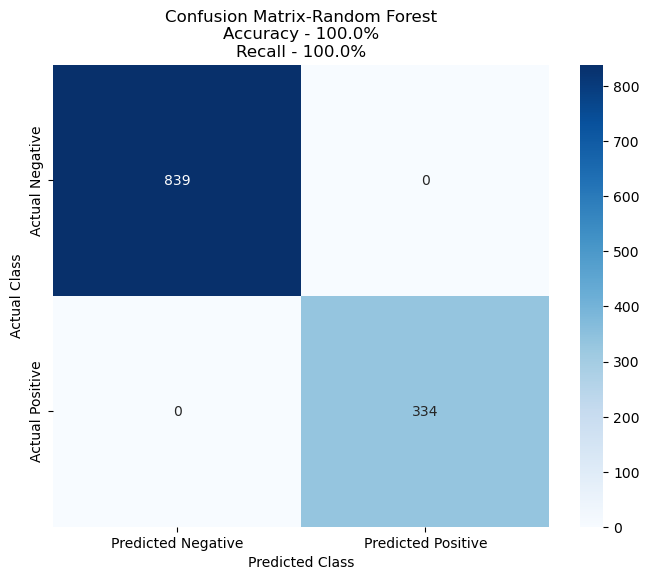

In [117]:
#Get subset of data for classification
data = df_PEPC[['XPE','XPC','YPE','YPC','ZPC','ZPE','RvPC','RvPE','intoxicated','pid','TAC_Reading']]

#Drop rows with NAN values
data = data.dropna()

#Store the training and testing features into a dataframe
X = data[['XPE','YPE','ZPE','XPC','YPC','ZPC']]
y_binary = data['intoxicated']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

#Implement logistic regression classification model
model = LogisticRegression()
print('Logistic Regression:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,False,'classification','Logistic Regression')

#Implement Naive Bayes classification model
model = GaussianNB()
print('\nNaive Bayes:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,False,'classification','Naive Bayes')

#Implement Random Forest classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
print('\nRandom Forest:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,True,'classification','Random Forest')


Traditional classification models like Logistic Regression and Naive Bayes results in around 70% accuracy. With this study it is important to predict the true positives correcly to identify intoxicated periods, hence we check the recall value of both the models and find that Naive Bayes offers a higher recall of 43% compared to 19% from Logistic Regression.

We then implement the Random Forest classification model as suggested in the study, and obtain an accuracy and recall value of 100%. In the study, the best result they could obtain was 77.5% accuracy and 70% recall. Through this project, we have explored the application of PE and PC and used them to predict the intoxication rate with a success rate of 100%, which could be used in the proposed JITAI systems for effective delivery of targeted messages.

### 7. Regression model based on PE and PC values

As the next step, we are building a regression model with the resultant vectors on PE and PC. With this, we will be able to predict the TAC reading values based on the PE and PC values.

In [118]:
#Store the training and testing features into a dataframe
X = data[['XPE','YPE','ZPE','XPC','YPC','ZPC']]
y_binary = data['TAC_Reading']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

#Implement linear regression model
model = LinearRegression()
print('Linear Regression:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,False,'regression','Linear Regression')

#Implement decision tree model
model = DecisionTreeRegressor(max_depth=5)
print('\nDecision Tree:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,False,'regression','Decision Tree')

#Implement random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
print('\nRandom Forest:')
y_pred=fit_train_plot(model,X_train, X_test, y_train, y_test ,False,'regression', 'Random Forest')

Linear Regression:
Mean Squared Error:0.0022
Mean Absolute Error:0.0373

Decision Tree:
Mean Squared Error:0.0012
Mean Absolute Error:0.0255

Random Forest:


Mean Squared Error:0.0
Mean Absolute Error:0.0


All the three regression models explored are providing good results as the MSE and MAE are close to 0. But, the Random Forest regressor is the best performing model compared to the other two models with a mean error of 0, suggesting that 100% of the test sample provided resulted in exact TAC readings.

### 7. Conclusion

The given dataset was cleaned, preprocessed and combined to calculate permutation entropy and complexity values across all the 3 axes of the accelerometer data. We plotted these PE, PC values against the TAC readings recorded from the SCRAM devices to observe patterns presented. We identified that PC values are more similar to the TAC readings than PE values. We validated this by normalizing the TAC threshold along with PE, PC values on the TAC reading range, and classified the intoxication and sober states. Using PE values, the classification had 66.6% accuracy rate and PC values had 80.1% accuracy rate. 

We utilized the calculated PE and PC values in traditional classfication and regression models, and found Random forest algorithm is the best at classifying and predicting between the two states with 100% accuracy rate and recall. Since this dataset was collected during a bar crawl event, it doesn't take normal day-to-day activity movement into account. Further training of the classifier and regressor models using real world activity accelerometer data like standing, walking and running is necessary to reduce 'false positive' predictions during movement detection. This will help create a robust classification model that can be used in the JITAI applications to alert for heavy drinking episodes.